#### Project 3 - Triangular mesh generator

In [1]:
using PyPlot, LinearAlgebra, Delaunator

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

# Delaunay triangulation `t` of array of nodes `p`
delaunay(p) = collect.(triangulate(p).triangles)

delaunay (generic function with 1 method)

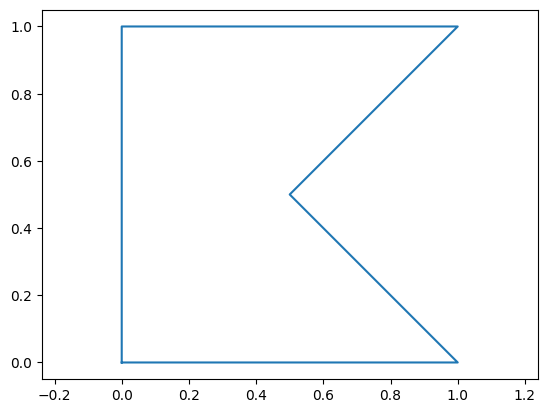

In [76]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

#### Problem 1 - Point in polygon

In [10]:
function inpolygon(p,pv)
    x,y = p[1],p[2]
    inside = false
    for i in 1:(length(pv)-1)
        xi = pv[i][1]
        yi = pv[i][2]
        xj = pv[i+1][1]
        yj = pv[i+1][2]
        if (((yi > y)!=(yj > y))&&(x < ((((xj - xi) * (y - yi)) / (yj - yi)) + xi)))
            inside = !inside
        end
    end
    return inside
end
inpolygon([0.8,0.3],pv)

false

#### Problem 2(a) - Triangle area

In [29]:
#given three point, we will calculate the area
tri = [[1,0.5], [2,1], [0,3]]
function tri_area(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    area = (1/2)*abs(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))
    return area
end
tri_area(tri)

1.5

#### Problem 2(b) - Triangle area

In [30]:
function tri_centroid(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    return [(1/3)*(x1+x2+x3),(1/3)*(y1+y2+y3)]
end
tri_centroid(tri)

2-element Vector{Float64}:
 1.0
 1.5

#### Problem 2(c) - Triangle circumcenter

In [31]:
#
function tri_centroid(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    d = 2*(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))
    x = 1/d*((x1^2+y1^2)*(y2 - y3)+(x2^2+y2^2)*(y3-y1)+(x3^2+y3^2)*(y1-y2))
    y = 1/d*((x1^2+y1^2)*(x3 - x2)+(x2^2+y2^2)*(x1-x3)+(x3^2+y3^2)*(x2-x1))
    return [x,y] 
end
tri_centroid(tri)

2-element Vector{Float64}:
 0.9166666666666666
 1.9166666666666665

#### Problem 3 - Mesh generator

neigher vertical nor horizental
dx : 0.017888543819998316
the x array is [0.0, 0.017888543819998316, 0.03577708763999663, 0.05366563145999495, 0.07155417527999326]
the y array is Any[0.10000000000000002, 0.06422291236000338, 0.028445824720006757, -0.007331262919989881, -0.043108350559986505]
neigher vertical nor horizental
dx : 0.017888543819998316
the x array is [0.1, 0.11788854381999832, 0.13577708763999663, 0.15366563145999496, 0.17155417527999328]
the y array is Any[-0.10000000000000002, -0.0642229123600034, -0.02844582472000677, 0.007331262919989881, 0.04310835055998653]
neigher vertical nor horizental
dx : 0.017888543819998316
the x array is [0.2, 0.21788854381999834, 0.23577708763999664, 0.253665631459995, 0.27155417527999326]
the y array is Any[0.1, 0.06422291236000334, 0.028445824720006736, -0.00733126291998998, -0.043108350559986526]
neigher vertical nor horizental
dx : 0.017888543819998323
the x array is [0.3, 0.3178885438199983, 0.33577708763999664, 0.35366563145999497, 0.3

85-element Vector{Any}:
 [0.0, 0.10000000000000002]
 [0.017888543819998316, 0.06422291236000338]
 [0.03577708763999663, 0.028445824720006757]
 [0.05366563145999495, -0.007331262919989881]
 [0.07155417527999326, -0.043108350559986505]
 [0.1, -0.10000000000000002]
 [0.11788854381999832, -0.0642229123600034]
 [0.13577708763999663, -0.02844582472000677]
 [0.15366563145999496, 0.007331262919989881]
 [0.17155417527999328, 0.04310835055998653]
 [0.2, 0.1]
 [0.21788854381999834, 0.06422291236000334]
 [0.23577708763999664, 0.028445824720006736]
 ⋮
 [0.33029437251522864, 0.4302943725152286]
 [0.30201010126776673, 0.4020101012677667]
 [0.2737258300203048, 0.3737258300203048]
 [0.2454415587728429, 0.3454415587728429]
 [0.217157287525381, 0.31715728752538097]
 [0.18887301627791914, 0.2888730162779191]
 [0.16058874503045723, 0.2605887450304572]
 [0.1323044737829953, 0.2323044737829953]
 [0.10402020253553346, 0.20402020253553343]
 [0.07573593128807155, 0.17573593128807152]
 [0.04745166004060963, 0.14

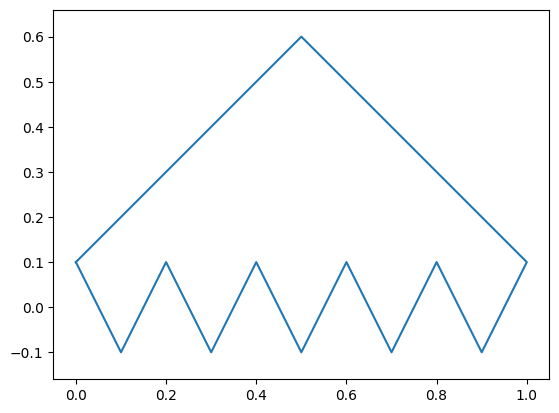

In [3]:
using LinearAlgebra

#given two points a and b of coordinate [x1,y1],[x2,y2], we will calculate the y coordinate
#of the given corresponding x on the line segment ab.
function y_coord(a,b,x)
    x1 = a[1]
    y1 = a[2]
    x2 = b[1]
    y2 = b[2]
    y = (x-x1+y1*(x2-x1)/(y2-y1))*((y2-y1)/(x2-x1))
    return y
end

#given the two point and the y coordinate, return the x coordinate on the edge
function x_coord(a,b,y)
    x1 = a[1]
    y1 = a[2]
    x2 = b[1]
    y2 = b[2]
    x = (y-y1)*(x2-x1)/(y2-y1)+x1
    return x
end

#this return the length between two points
function cartesion_distance(a,b)
    return sqrt((b[1]-a[1])^2+(b[2]-a[2])^2)
end

#We will first create node points p along each polygon segment and store them in node(it will also include the polygon node), 
#separated by a distance approximately equal to hmax. Return all the node on the line
function equi_node(pv,hmax)
    node = []
    for i in 1:(length(pv)-1)
        if (pv[i+1][1]-pv[i][1] !=0)&(pv[i+1][2]-pv[i][2] != 0) #this is when the edge is neigher horizental nor veritical
            println("neigher vertical nor horizental")
            dx = hmax*(pv[i+1][1]-pv[i][1])/cartesion_distance(pv[i+1],pv[i])
            println("dx : ", dx)
            xarray = collect(pv[i][1]:dx:(pv[i+1][1]-dx))
            println("the x array is ", xarray)
            yarray = []
            for x in xarray
                push!(yarray,y_coord(pv[i],pv[i+1],x))
            end
            println("the y array is ", yarray)
            if length(xarray) != length(yarray)
                println("ok this is not solving the problem")
            end
            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
        elseif ((pv[i+1][1]-pv[i][1] == 0)&(pv[i+1][2]-pv[i][2] != 0)) #this is when the edge is veritical
            println("vertical")
            dy = hmax*(pv[i+1][2]-pv[i][2])/cartesion_distance(pv[i+1],pv[i])
            println("dy : ", dy)
            yarray = collect(pv[i][2]:dy:(pv[i+1][2]-dy))
            xarray = []
            if length(xarray) != length(yarray)
                println("ok this is not solving the problem")
            end
            for y in yarray
                push!(xarray,pv[i][1])
            end
            println("the x array is ", xarray)
            println("the y array is ", yarray)

            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
        elseif (pv[i+1][2]-pv[i][2] == 0)&(pv[i+1][1]-pv[i][1] !=0) #this is when the line is horizental
            println("horizental")
            dx = hmax*(pv[i+1][1]-pv[i][1])/cartesion_distance(pv[i+1],pv[i])
            println("dx : ", dx)
            xarray = collect(pv[i][1]:dx:(pv[i+1][1]-dx))
            println("the x array is ", xarray)
            yarray = []
            for x in xarray
                push!(yarray,pv[i][2])
            end
            println("the y array is ", yarray)
            if length(xarray) != length(yarray)
                println("ok this is not solving the problem")
            end
            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
            
        end
    end
    push!(node,pv[1])
    return node
end

function pmesh(pv,hmax)
    node = [] #We keep track of all the nodes show up
    poly = pv #Store the information about the original polygon
end
#pv = [[0,0], [1,0], [0.5,0.5], [1,1], [0,1], [0,0]]
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
node = equi_node(pv,0.04)
display(node)
#x_coord([0.5,0.5],[1,1],0.5)
plot(first.(node), last.(node))
axis("equal");
